In [1]:
import numpy as np 
import pandas as pd 

import os

In [2]:
# Paths to VOC directories
base_dir = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val'
images_dir = os.path.join(base_dir, 'JPEGImages')
annotations_dir = os.path.join(base_dir, 'Annotations')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')

# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

# Get all files from trainval.txt
trainval_files = get_files_from_split(os.path.join(sets_dir, 'trainval.txt'))
np.random.shuffle(trainval_files)  # Shuffle to randomize the split

split_index = int(len(trainval_files) * 0.9)
train_files = trainval_files[:split_index]
val_files = trainval_files[split_index:]

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os
import random
from torchvision import transforms

class RotationDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        """
        file_list: lista dei nomi dei file (es. ['2008_000001', ...])
        root_dir: cartella dove sono le immagini JPEG
        """
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        
        # Mappa le rotazioni in classi
        self.angle_to_label = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.root_dir, filename + ".jpg")
        
        image = Image.open(img_path).convert("RGB")
        
        # 1. Scegliamo una rotazione casuale
        angle = random.choice([0, 90, 180, 270])
        
        # 2. Ruotiamo l'immagine
        # Nota: expand=True adatta la dimensione se l'img non è quadrata
        rotated_image = image.rotate(-angle, expand=True) 
        
        # 3. Creiamo la label per la rotazione
        label_rotation = self.angle_to_label[angle]
        
        # 4. Applichiamo le trasformazioni standard (Resize, ToTensor, Normalize)
        if self.transform:
            rotated_image = self.transform(rotated_image)
            
        return rotated_image, label_rotation

In [4]:
# Esempio di utilizzo
transform_pipeline_160 = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomCrop(160),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_pipeline_224 = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_pipeline_299 = transforms.Compose([
    transforms.Resize(320),
    transforms.RandomCrop(299),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Usa la tua lista 'train_files' generata nel tuo codice precedente
train_dataset = RotationDataset(train_files, images_dir, transform=transform_pipeline_160)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import time
import copy

# --- 1. CONFIGURAZIONE ---
BATCH_SIZE = 32
NUM_EPOCHS = 75
LEARNING_RATE = 0.01
PATIENTCE = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {DEVICE}")

# --- 2. DATALOADERS ---
# Creiamo il dataset di validazione (assicurati di aver definito val_files come prima)
val_dataset = RotationDataset(val_files, images_dir, transform=transform_pipeline_160)

# Creiamo i generatori di batch
# --- 2. DATALOADERS ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 3. DEFINIZIONE DEL MODELLO ---
# Scarichiamo una EfficientNet B0 pre-addestrata
model = models.inception_v3(weights=None, aux_logits=False)

# Congeliamo i pesi (facoltativo, ma velocizza se hai pochi dati)
# per un task semplice come la rotazione, spesso conviene NON congelare tutto, 
# ma se vuoi farlo:
# for param in model.parameters():
#     param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),  # Hidden layer (maintains size or reduces)
    nn.ReLU(),                      # Non-linearity (Crucial!)
    nn.Linear(num_ftrs, 4)          # Output layer
)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print(torch.cuda.device_count(), "devices")
    
model = model.to(DEVICE)

# --- 4. LOSS E OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# --- 5. FUNZIONE DI TRAINING ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=3):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    # --- FIX 1: Inizializziamo la variabile di fase ---
    current_phase = 0  # 0: 160px, 1: 224px, 2: 300px
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    epochs_no_improve = 0 # Inizializziamo anche questo fuori

    # Funzione helper per gestire il cambio risoluzione ed evitare codice duplicato
    def change_resolution(new_phase, reason):
        nonlocal best_loss, epochs_no_improve, current_phase
        
        if new_phase == 1:
            print(f"\n>>> {reason}: Passaggio a 224x224 (Phase 1)...")
            # Assicurati che transform_pipeline_224 sia visibile qui o passalo come argomento
            train_loader.dataset.transform = transform_pipeline_224
            val_loader.dataset.transform = transform_pipeline_224
        elif new_phase == 2:
            print(f"\n>>> {reason}: Passaggio a 299x299 (Phase 2)...")
            train_loader.dataset.transform = transform_pipeline_299
            val_loader.dataset.transform = transform_pipeline_299
        
        # Reset metriche per la nuova fase
        current_phase = new_phase
        best_loss = float('inf')
        epochs_no_improve = 0
        
        # Opzionale: Resettare il Learning Rate se è diventato troppo basso?
        # Per ora lasciamo che il CosineAnnealing continui, ma tieni a mente questo aspetto.

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs} (Phase {current_phase})')
        print('-' * 10)

        # --- GESTIONE CAMBIO RISOLUZIONE BASATA SU EPOCA (FORZATURA) ---
        # Se siamo ancora nella fase 0 e arriviamo all'epoca 25, forza il cambio
        if epoch == 25 and current_phase == 0:
            change_resolution(1, "Epoch 25 raggiunta")
        
        # Se siamo ancora nella fase 1 e arriviamo all'epoca 50, forza il cambio
        elif epoch == 50 and current_phase == 1:
            change_resolution(2, "Epoch 50 raggiunta")

        # Ogni epoca ha una fase di training e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Itera sui dati
            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.item() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                # Step dello scheduler (di solito si fa dopo la validazione)
                scheduler.step() 

                # --- LOGICA EARLY STOPPING E PROGRESSIVE RESIZING ---
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    # print(" -> Miglioramento!")
                else:
                    epochs_no_improve += 1
                    print(f" -> Nessun miglioramento per {epochs_no_improve}/{patience} epoche.")

        print() 

        # Controllo fine pazienza
        if epochs_no_improve >= patience:
            if current_phase == 0:
                change_resolution(1, "Early Stopping (Patience)")
            elif current_phase == 1:
                change_resolution(2, "Early Stopping (Patience)")
            else:
                # Siamo alla fase 2 (300x300) e la pazienza è finita -> STOP VERO
                print(f"Early Stopping Finale attivato! Training terminato alla fase {current_phase}.")
                break

    time_elapsed = time.time() - start_time
    print(f'Training completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Carica i pesi migliori prima di ritornare
    model.load_state_dict(best_model_wts)
    return model, history



# --- 6. AVVIO DEL TRAINING ---
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, patience=PATIENTCE)

# --- 7. SALVATAGGIO DEL MODELLO ---
torch.save(trained_model.state_dict(), 'fullTraining_inception_v3_mixcrop.pth')
print("Modello salvato come fullTraining_inception_v3_mixcrop.pth")

Usando device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/75 (Phase 0)
----------
train Loss: 1.4036 Acc: 0.2623
val Loss: 1.3782 Acc: 0.2877

Epoch 2/75 (Phase 0)
----------
train Loss: 1.3715 Acc: 0.3025
val Loss: 1.3660 Acc: 0.3423

Epoch 3/75 (Phase 0)
----------
train Loss: 1.3350 Acc: 0.3569
val Loss: 1.3805 Acc: 0.3640
 -> Nessun miglioramento per 1/7 epoche.

Epoch 4/75 (Phase 0)
----------
train Loss: 1.2943 Acc: 0.3905
val Loss: 1.3054 Acc: 0.3908

Epoch 5/75 (Phase 0)
----------
train Loss: 1.2802 Acc: 0.4113
val Loss: 1.2870 Acc: 0.4012

Epoch 6/75 (Phase 0)
----------
train Loss: 1.2614 Acc: 0.4228
val Loss: 1.2707 Acc: 0.3917

Epoch 7/75 (Phase 0)
----------
train Loss: 1.2471 Acc: 0.4303
val Loss: 1.2274 Acc: 0.4333

Epoch 8/75 (Phase 0)
----------
train Loss: 1.2371 Acc: 0.4379
val Loss: 1.2334 Acc: 0.4359
 -> Nessun miglioramento per 1/7 epoche.

Epoch 9/75 (Phase 0)
----------
train Loss: 1.2308 Acc: 0.4422
val Loss: 1.2478 Acc: 0.4272
 -> Nessun miglioramento per 2/7 epoche.

Epoch 10/75 (Phase 0)
----------
train L

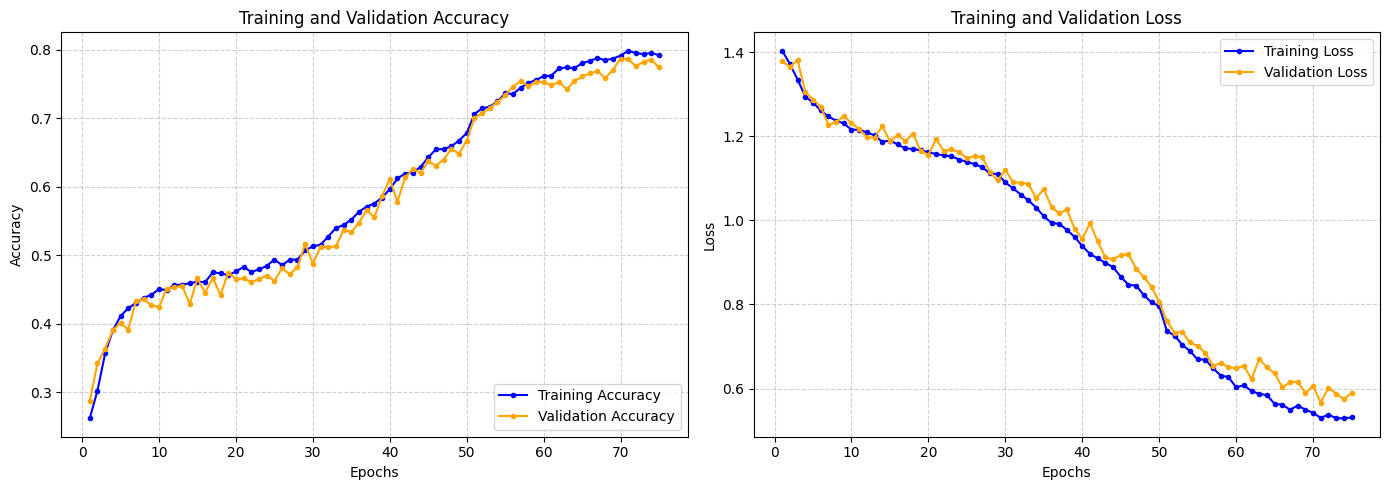

In [6]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Creiamo un array con il numero delle epoche effettive
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # --- GRAFICO 1: ACCURACY ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- GRAFICO 2: LOSS ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Esegui la funzione passando la history ottenuta dal training
if 'history' in locals():
    plot_training_results(history)
else:
    print("Errore: Variabile 'history' non trovata. Assicurati che la funzione di training la restituisca.")

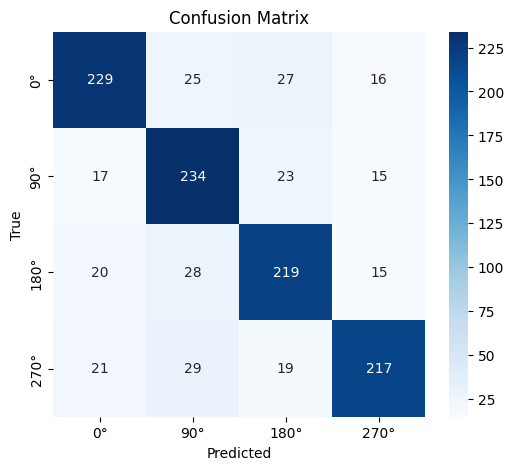

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, val_loader, class_names):
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move to CPU and append to lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names (based on your rotation angles)
class_names = ['0°', '90°', '180°', '270°']

# Run the confusion matrix function
plot_confusion_matrix(model, val_loader, class_names)